In [13]:
# Importaciones necesarias para limpieza de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# Configuración para mostrar más columnas y filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Librerías importadas exitosamente!")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

Librerías importadas exitosamente!
Pandas version: 2.3.1
Numpy version: 2.3.2


In [14]:
# Función para cargar datos eficientemente
def load_dataset_info(file_path):
    """Carga información básica del dataset sin cargar todo en memoria"""
    # Primero leemos solo las primeras filas para ver la estructura
    sample = pd.read_csv(file_path, nrows=1000)
    
    # Obtenemos información del archivo completo
    total_lines = sum(1 for line in open(file_path, 'r')) - 1  # -1 por el header
    
    return {
        'shape_sample': sample.shape,
        'total_rows': total_lines,
        'columns': sample.columns.tolist(),
        'dtypes': sample.dtypes.to_dict(),
        'sample_data': sample
    }

# Cargar información de todos los datasets
datasets_info = {}
dataset_files = [
    'Base.csv',
    'Variant I.csv', 
    'Variant II.csv',
    'Variant III.csv',
    'Variant IV.csv',
    'Variant V.csv'
]

print("Cargando información de los datasets...")
for file in dataset_files:
    file_path = f'bank_account_fraud_dataset/{file}'
    try:
        datasets_info[file] = load_dataset_info(file_path)
        print(f"✓ {file}: {datasets_info[file]['total_rows']:,} filas, {len(datasets_info[file]['columns'])} columnas")
    except Exception as e:
        print(f"✗ Error cargando {file}: {e}")

print(f"\nTotal de archivos procesados: {len(datasets_info)}")

Cargando información de los datasets...
✓ Base.csv: 1,000,000 filas, 32 columnas
✓ Base.csv: 1,000,000 filas, 32 columnas
✓ Variant I.csv: 1,000,000 filas, 32 columnas
✓ Variant I.csv: 1,000,000 filas, 32 columnas
✓ Variant II.csv: 1,000,000 filas, 32 columnas
✓ Variant II.csv: 1,000,000 filas, 32 columnas
✓ Variant III.csv: 1,000,000 filas, 34 columnas
✓ Variant III.csv: 1,000,000 filas, 34 columnas
✓ Variant IV.csv: 1,000,000 filas, 32 columnas
✓ Variant IV.csv: 1,000,000 filas, 32 columnas
✓ Variant V.csv: 1,000,000 filas, 34 columnas

Total de archivos procesados: 6
✓ Variant V.csv: 1,000,000 filas, 34 columnas

Total de archivos procesados: 6


In [15]:
# Análisis exploratorio de la estructura de los datos
print("=== ANÁLISIS EXPLORATORIO INICIAL ===\n")

# Verificar si todos los datasets tienen las mismas columnas
all_columns = []
for file, info in datasets_info.items():
    all_columns.append(set(info['columns']))
    print(f"{file}:")
    print(f"  - Columnas: {len(info['columns'])}")
    print(f"  - Filas: {info['total_rows']:,}")
    print(f"  - Primeras columnas: {info['columns'][:5]}")
    print()

# Verificar consistencia de columnas entre datasets
if len(set(frozenset(cols) for cols in all_columns)) == 1:
    print("✓ Todos los datasets tienen las mismas columnas")
    common_columns = list(all_columns[0])
    print(f"Total de columnas: {len(common_columns)}")
    print(f"Columnas: {common_columns}")
else:
    print("⚠ Los datasets tienen diferentes columnas")
    for i, (file, info) in enumerate(datasets_info.items()):
        unique_cols = all_columns[i] - all_columns[0] if i > 0 else set()
        if unique_cols:
            print(f"  {file} tiene columnas únicas: {unique_cols}")

# Mostrar tipos de datos del primer dataset (Base.csv)
if 'Base.csv' in datasets_info:
    print(f"\n=== TIPOS DE DATOS (Base.csv) ===")
    base_info = datasets_info['Base.csv']
    for col, dtype in base_info['dtypes'].items():
        print(f"{col}: {dtype}")

=== ANÁLISIS EXPLORATORIO INICIAL ===

Base.csv:
  - Columnas: 32
  - Filas: 1,000,000
  - Primeras columnas: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count']

Variant I.csv:
  - Columnas: 32
  - Filas: 1,000,000
  - Primeras columnas: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count']

Variant II.csv:
  - Columnas: 32
  - Filas: 1,000,000
  - Primeras columnas: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count']

Variant III.csv:
  - Columnas: 34
  - Filas: 1,000,000
  - Primeras columnas: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count']

Variant IV.csv:
  - Columnas: 32
  - Filas: 1,000,000
  - Primeras columnas: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count']

Variant V.csv:
  - Col

In [16]:
# Función para análisis detallado de calidad de datos
def analyze_data_quality(df, dataset_name):
    """Analiza la calidad de los datos en un DataFrame"""
    print(f"\n=== ANÁLISIS DE CALIDAD: {dataset_name} ===")
    
    # Información básica
    print(f"Forma del dataset: {df.shape}")
    print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Valores faltantes
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    if missing_data.sum() > 0:
        print(f"\n📊 VALORES FALTANTES:")
        missing_df = pd.DataFrame({
            'Columna': missing_data.index,
            'Valores_Faltantes': missing_data.values,
            'Porcentaje': missing_percent.values
        })
        missing_df = missing_df[missing_df['Valores_Faltantes'] > 0].sort_values('Porcentaje', ascending=False)
        print(missing_df.to_string(index=False))
    else:
        print("✓ No hay valores faltantes")
    
    # Duplicados
    duplicates = df.duplicated().sum()
    print(f"\n🔄 DUPLICADOS: {duplicates:,} filas ({(duplicates/len(df)*100):.2f}%)")
    
    # Estadísticas por tipo de columna
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    print(f"\n📈 TIPOS DE COLUMNAS:")
    print(f"  - Numéricas: {len(numeric_cols)}")
    print(f"  - Categóricas: {len(categorical_cols)}")
    
    # Valores únicos en columnas categóricas
    if len(categorical_cols) > 0:
        print(f"\n🏷️ VALORES ÚNICOS (Categóricas):")
        for col in categorical_cols[:10]:  # Solo las primeras 10
            unique_count = df[col].nunique()
            total_count = len(df[col])
            print(f"  {col}: {unique_count:,} únicos de {total_count:,} ({(unique_count/total_count*100):.1f}%)")
    
    return {
        'missing_data': missing_df if missing_data.sum() > 0 else None,
        'duplicates': duplicates,
        'numeric_cols': numeric_cols.tolist(),
        'categorical_cols': categorical_cols.tolist()
    }

# Analizar el dataset Base.csv completo (o una muestra grande)
print("Cargando muestra del dataset Base.csv para análisis detallado...")

# Cargar una muestra más grande para análisis
sample_size = 50000  # Ajustar según la memoria disponible
base_sample = pd.read_csv('bank_account_fraud_dataset/Base.csv', nrows=sample_size)

# Realizar análisis de calidad
quality_analysis = analyze_data_quality(base_sample, f"Base.csv (muestra de {sample_size:,} filas)")

# Mostrar primeras filas
print(f"\n=== PRIMERAS 5 FILAS ===")
print(base_sample.head())

Cargando muestra del dataset Base.csv para análisis detallado...

=== ANÁLISIS DE CALIDAD: Base.csv (muestra de 50,000 filas) ===
Forma del dataset: (50000, 32)
Memoria utilizada: 22.92 MB
✓ No hay valores faltantes

🔄 DUPLICADOS: 0 filas (0.00%)

📈 TIPOS DE COLUMNAS:
  - Numéricas: 27
  - Categóricas: 5

🏷️ VALORES ÚNICOS (Categóricas):
  payment_type: 5 únicos de 50,000 (0.0%)
  employment_status: 7 únicos de 50,000 (0.0%)
  housing_status: 7 únicos de 50,000 (0.0%)
  source: 2 únicos de 50,000 (0.0%)
  device_os: 5 únicos de 50,000 (0.0%)

=== PRIMERAS 5 FILAS ===
   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307       

Generando visualizaciones de calidad de datos...


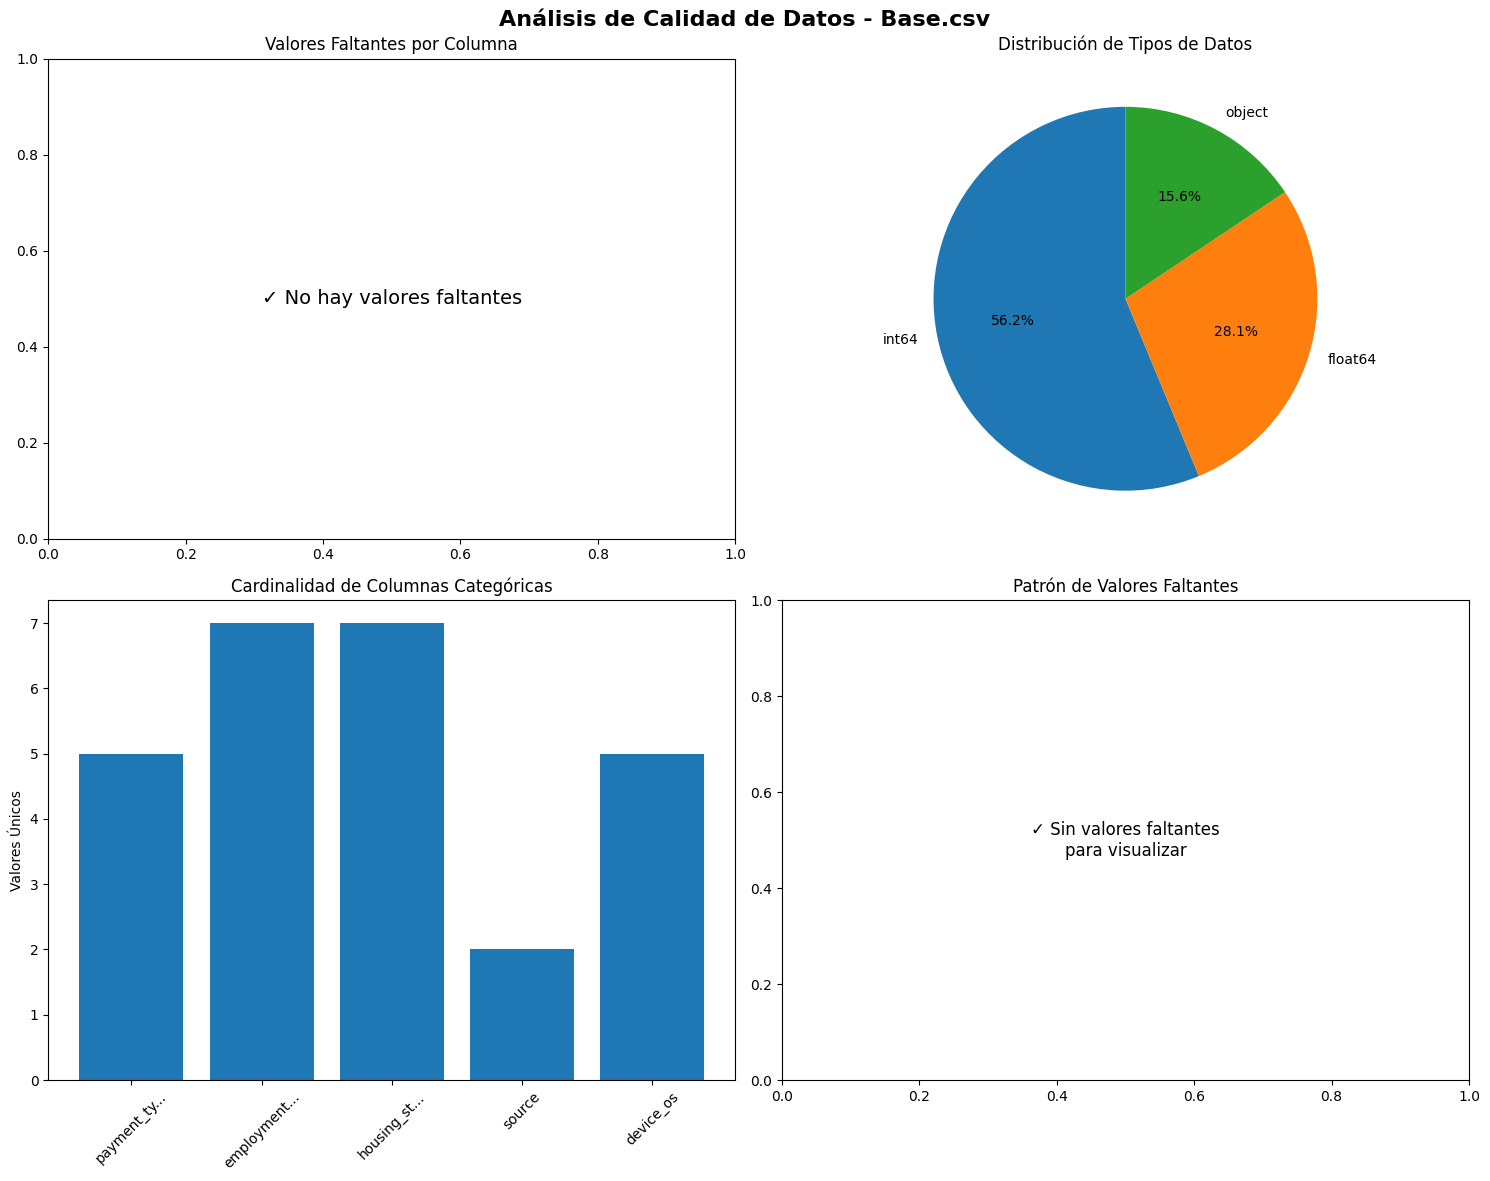

In [17]:
# Visualización de problemas de calidad de datos
def visualize_data_quality(df, dataset_name):
    """Crea visualizaciones para problemas de calidad de datos"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis de Calidad de Datos - {dataset_name}', fontsize=16, fontweight='bold')
    
    # 1. Valores faltantes
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
        axes[0,0].barh(range(len(missing_data)), missing_data.values)
        axes[0,0].set_yticks(range(len(missing_data)))
        axes[0,0].set_yticklabels(missing_data.index)
        axes[0,0].set_xlabel('Número de Valores Faltantes')
        axes[0,0].set_title('Valores Faltantes por Columna')
        
        # Agregar porcentajes
        for i, v in enumerate(missing_data.values):
            axes[0,0].text(v + max(missing_data) * 0.01, i, f'{(v/len(df)*100):.1f}%', va='center')
    else:
        axes[0,0].text(0.5, 0.5, '✓ No hay valores faltantes', 
                      ha='center', va='center', transform=axes[0,0].transAxes, fontsize=14)
        axes[0,0].set_title('Valores Faltantes por Columna')
    
    # 2. Distribución de tipos de datos
    dtypes_count = df.dtypes.value_counts()
    axes[0,1].pie(dtypes_count.values, labels=dtypes_count.index, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Distribución de Tipos de Datos')
    
    # 3. Cardinalidad de columnas categóricas
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        cardinality = [df[col].nunique() for col in categorical_cols[:10]]
        axes[1,0].bar(range(len(cardinality)), cardinality)
        axes[1,0].set_xticks(range(len(cardinality)))
        axes[1,0].set_xticklabels([col[:10] + '...' if len(col) > 10 else col 
                                  for col in categorical_cols[:10]], rotation=45)
        axes[1,0].set_ylabel('Valores Únicos')
        axes[1,0].set_title('Cardinalidad de Columnas Categóricas')
    else:
        axes[1,0].text(0.5, 0.5, 'No hay columnas categóricas', 
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Cardinalidad de Columnas Categóricas')
    
    # 4. Mapa de valores faltantes (usando missingno)
    if missing_data.sum() > 0:
        # Crear subplot para missingno
        plt.subplot(2, 2, 4)
        msno.matrix(df.sample(min(1000, len(df))), ax=plt.gca(), sparkline=False)
        plt.title('Patrón de Valores Faltantes')
    else:
        axes[1,1].text(0.5, 0.5, '✓ Sin valores faltantes\npara visualizar', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Patrón de Valores Faltantes')
    
    plt.tight_layout()
    plt.show()

# Crear visualizaciones para el dataset Base
print("Generando visualizaciones de calidad de datos...")
visualize_data_quality(base_sample, "Base.csv")

In [18]:
# Funciones para limpieza de datos
class DataCleaner:
    """Clase para aplicar técnicas de limpieza de datos"""
    
    def __init__(self):
        self.cleaning_report = {}
    
    def handle_missing_values(self, df, strategy='auto'):
        """
        Maneja valores faltantes según diferentes estrategias
        
        Estrategias:
        - 'auto': Automática basada en el tipo de datos y porcentaje de faltantes
        - 'drop': Elimina filas con valores faltantes
        - 'fill_numeric': Rellena con media/mediana
        - 'fill_categorical': Rellena con moda
        """
        df_clean = df.copy()
        missing_info = {}
        
        for col in df.columns:
            missing_count = df[col].isnull().sum()
            missing_percent = (missing_count / len(df)) * 100
            
            if missing_count > 0:
                if strategy == 'auto':
                    # Estrategia automática
                    if missing_percent > 50:
                        # Si más del 50% está faltante, considerar eliminar la columna
                        print(f"⚠️ {col}: {missing_percent:.1f}% faltante - Considerar eliminar")
                        missing_info[col] = f"Alto porcentaje faltante ({missing_percent:.1f}%)"
                    
                    elif df[col].dtype in ['object']:
                        # Categóricas: rellenar con moda
                        mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown'
                        df_clean[col].fillna(mode_value, inplace=True)
                        missing_info[col] = f"Rellenado con moda: {mode_value}"
                        print(f"✓ {col}: Rellenado con moda '{mode_value}'")
                    
                    else:
                        # Numéricas: rellenar con mediana (más robusta que la media)
                        median_value = df[col].median()
                        df_clean[col].fillna(median_value, inplace=True)
                        missing_info[col] = f"Rellenado con mediana: {median_value}"
                        print(f"✓ {col}: Rellenado con mediana {median_value}")
        
        self.cleaning_report['missing_values'] = missing_info
        return df_clean
    
    def remove_duplicates(self, df, subset=None):
        """Elimina filas duplicadas"""
        initial_count = len(df)
        df_clean = df.drop_duplicates(subset=subset)
        duplicates_removed = initial_count - len(df_clean)
        
        print(f"✓ Duplicados eliminados: {duplicates_removed:,} filas ({(duplicates_removed/initial_count*100):.2f}%)")
        self.cleaning_report['duplicates'] = duplicates_removed
        
        return df_clean
    
    def detect_outliers(self, df, method='iqr', columns=None):
        """
        Detecta outliers usando diferentes métodos
        
        Métodos:
        - 'iqr': Rango intercuartílico (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
        - 'zscore': Z-score (valores > 3 desviaciones estándar)
        """
        numeric_cols = df.select_dtypes(include=[np.number]).columns if columns is None else columns
        outliers_info = {}
        
        for col in numeric_cols:
            if method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                
            elif method == 'zscore':
                z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
                outliers = df[z_scores > 3]
            
            outliers_count = len(outliers)
            outliers_percent = (outliers_count / len(df)) * 100
            
            outliers_info[col] = {
                'count': outliers_count,
                'percentage': outliers_percent,
                'method': method
            }
            
            print(f"📊 {col}: {outliers_count:,} outliers ({outliers_percent:.2f}%) - método {method}")
        
        self.cleaning_report['outliers'] = outliers_info
        return outliers_info
    
    def standardize_data_types(self, df):
        """Estandariza tipos de datos"""
        df_clean = df.copy()
        type_changes = {}
        
        for col in df.columns:
            original_type = df[col].dtype
            
            # Intentar convertir columnas que parecen numéricas
            if df[col].dtype == 'object':
                # Verificar si es numérica
                try:
                    # Remover espacios en blanco y convertir a numérico
                    df_clean[col] = pd.to_numeric(df[col].astype(str).str.strip(), errors='coerce')
                    if not df_clean[col].isnull().all():
                        type_changes[col] = f"{original_type} -> {df_clean[col].dtype}"
                        print(f"✓ {col}: Convertido a numérico")
                    else:
                        df_clean[col] = df[col]  # Revertir si todas son NaN
                except:
                    pass
        
        self.cleaning_report['type_changes'] = type_changes
        return df_clean
    
    def get_cleaning_summary(self):
        """Retorna un resumen de todas las operaciones de limpieza realizadas"""
        return self.cleaning_report

# Crear instancia del limpiador
cleaner = DataCleaner()
print("Clase DataCleaner creada exitosamente!")
print("Métodos disponibles:")
print("- handle_missing_values(): Maneja valores faltantes")
print("- remove_duplicates(): Elimina duplicados") 
print("- detect_outliers(): Detecta valores atípicos")
print("- standardize_data_types(): Estandariza tipos de datos")

Clase DataCleaner creada exitosamente!
Métodos disponibles:
- handle_missing_values(): Maneja valores faltantes
- remove_duplicates(): Elimina duplicados
- detect_outliers(): Detecta valores atípicos
- standardize_data_types(): Estandariza tipos de datos


In [19]:
# Aplicar técnicas de limpieza al dataset Base.csv
print("=== APLICANDO TÉCNICAS DE LIMPIEZA ===\n")

# Paso 1: Estandarizar tipos de datos
print("1. Estandarizando tipos de datos...")
base_cleaned = cleaner.standardize_data_types(base_sample)

# Paso 2: Manejar valores faltantes
print("\n2. Manejando valores faltantes...")
base_cleaned = cleaner.handle_missing_values(base_cleaned, strategy='auto')

# Paso 3: Eliminar duplicados
print("\n3. Eliminando duplicados...")
base_cleaned = cleaner.remove_duplicates(base_cleaned)

# Paso 4: Detectar outliers (solo detectar, no eliminar automáticamente)
print("\n4. Detectando outliers...")
outliers_info = cleaner.detect_outliers(base_cleaned, method='iqr')

# Comparar antes vs después
print(f"\n=== COMPARACIÓN ANTES VS DESPUÉS ===")
print(f"Filas originales: {len(base_sample):,}")
print(f"Filas después de limpieza: {len(base_cleaned):,}")
print(f"Diferencia: {len(base_sample) - len(base_cleaned):,} filas eliminadas")

# Verificar valores faltantes después de la limpieza
missing_after = base_cleaned.isnull().sum().sum()
print(f"Valores faltantes después de limpieza: {missing_after:,}")

# Mostrar resumen de limpieza
print(f"\n=== RESUMEN DE OPERACIONES DE LIMPIEZA ===")
cleaning_summary = cleaner.get_cleaning_summary()
for operation, details in cleaning_summary.items():
    print(f"\n{operation.upper()}:")
    if isinstance(details, dict):
        for key, value in details.items():
            print(f"  - {key}: {value}")
    else:
        print(f"  - {details}")

# Guardar dataset limpio (opcional)
print(f"\n¿Deseas guardar el dataset limpio? El archivo tendría {len(base_cleaned):,} filas y {len(base_cleaned.columns)} columnas.")
print("Para guardarlo, ejecuta: base_cleaned.to_csv('bank_account_fraud_dataset/Base_cleaned.csv', index=False)")

=== APLICANDO TÉCNICAS DE LIMPIEZA ===

1. Estandarizando tipos de datos...

2. Manejando valores faltantes...

3. Eliminando duplicados...
✓ Duplicados eliminados: 0 filas (0.00%)

4. Detectando outliers...
📊 fraud_bool: 573 outliers (1.15%) - método iqr
📊 income: 0 outliers (0.00%) - método iqr
📊 name_email_similarity: 0 outliers (0.00%) - método iqr
📊 prev_address_months_count: 5,496 outliers (10.99%) - método iqr
📊 current_address_months_count: 1,705 outliers (3.41%) - método iqr
📊 customer_age: 61 outliers (0.12%) - método iqr
📊 days_since_request: 3,678 outliers (7.36%) - método iqr
📊 intended_balcon_amount: 4,918 outliers (9.84%) - método iqr
📊 zip_count_4w: 52 outliers (0.10%) - método iqr
📊 velocity_6h: 595 outliers (1.19%) - método iqr
📊 velocity_24h: 341 outliers (0.68%) - método iqr
📊 velocity_4w: 2,780 outliers (5.56%) - método iqr
📊 bank_branch_count_8w: 10,078 outliers (20.16%) - método iqr
📊 date_of_birth_distinct_emails_4w: 388 outliers (0.78%) - método iqr
📊 credit_ri

In [20]:
# Análisis post-limpieza y función para procesar todos los datasets
def compare_before_after(df_original, df_cleaned, dataset_name):
    """Compara estadísticas antes y después de la limpieza"""
    
    print(f"\n=== COMPARACIÓN DETALLADA: {dataset_name} ===")
    
    # Estadísticas generales
    print(f"📊 ESTADÍSTICAS GENERALES:")
    print(f"  Filas: {len(df_original):,} → {len(df_cleaned):,} ({len(df_cleaned)-len(df_original):+,})")
    print(f"  Columnas: {len(df_original.columns)} → {len(df_cleaned.columns)} ({len(df_cleaned.columns)-len(df_original.columns):+})")
    print(f"  Valores faltantes: {df_original.isnull().sum().sum():,} → {df_cleaned.isnull().sum().sum():,}")
    print(f"  Memoria: {df_original.memory_usage(deep=True).sum()/1024**2:.1f} MB → {df_cleaned.memory_usage(deep=True).sum()/1024**2:.1f} MB")
    
    # Cambios en tipos de datos
    original_types = df_original.dtypes.value_counts()
    cleaned_types = df_cleaned.dtypes.value_counts()
    
    print(f"\n📈 TIPOS DE DATOS:")
    all_types = set(original_types.index) | set(cleaned_types.index)
    for dtype in all_types:
        orig_count = original_types.get(dtype, 0)
        clean_count = cleaned_types.get(dtype, 0)
        if orig_count != clean_count:
            print(f"  {dtype}: {orig_count} → {clean_count} ({clean_count-orig_count:+})")
    
    # Calidad de datos mejorada
    orig_quality_score = calculate_quality_score(df_original)
    clean_quality_score = calculate_quality_score(df_cleaned)
    
    print(f"\n⭐ PUNTUACIÓN DE CALIDAD:")
    print(f"  Antes: {orig_quality_score:.1f}/100")
    print(f"  Después: {clean_quality_score:.1f}/100")
    print(f"  Mejora: {clean_quality_score - orig_quality_score:+.1f} puntos")

def calculate_quality_score(df):
    """Calcula una puntuación de calidad de datos (0-100)"""
    score = 100
    
    # Penalizar por valores faltantes
    missing_penalty = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 30
    score -= missing_penalty
    
    # Penalizar por duplicados
    duplicate_penalty = (df.duplicated().sum() / len(df)) * 20
    score -= duplicate_penalty
    
    # Bonificar por tipos de datos apropiados
    numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
    if numeric_cols > 0:
        score += min(10, numeric_cols * 2)
    
    return max(0, score)

def process_all_datasets():
    """Procesa todos los datasets con las técnicas de limpieza"""
    
    print("=== PROCESANDO TODOS LOS DATASETS ===\n")
    
    processed_datasets = {}
    
    for file in dataset_files:
        print(f"🔄 Procesando {file}...")
        
        try:
            # Cargar dataset (muestra para demostración)
            file_path = f'bank_account_fraud_dataset/{file}'
            df_original = pd.read_csv(file_path, nrows=1000000)  # Muestra de 10k filas
            
            # Crear nuevo limpiador para cada dataset
            dataset_cleaner = DataCleaner()
            
            # Aplicar limpieza
            df_cleaned = dataset_cleaner.standardize_data_types(df_original)
            df_cleaned = dataset_cleaner.handle_missing_values(df_cleaned, strategy='auto')
            df_cleaned = dataset_cleaner.remove_duplicates(df_cleaned)
            
            # Detectar outliers
            outliers = dataset_cleaner.detect_outliers(df_cleaned)
            
            # Guardar resultados
            processed_datasets[file] = {
                'original': df_original,
                'cleaned': df_cleaned,
                'cleaner': dataset_cleaner,
                'outliers': outliers
            }
            
            # Mostrar comparación
            compare_before_after(df_original, df_cleaned, file)
            
            print(f"✓ {file} procesado exitosamente\n")
            
        except Exception as e:
            print(f"❌ Error procesando {file}: {e}\n")
    
    return processed_datasets

# Comparar el dataset Base antes y después de limpieza
compare_before_after(base_sample, base_cleaned, "Base.csv (muestra)")

print("\n" + "="*60)
print("🎯 SIGUIENTE PASO: Ejecutar process_all_datasets() para procesar todos los archivos")
print("Nota: Esto puede tomar varios minutos dependiendo del tamaño de los datos")


=== COMPARACIÓN DETALLADA: Base.csv (muestra) ===
📊 ESTADÍSTICAS GENERALES:
  Filas: 50,000 → 50,000 (+0)
  Columnas: 32 → 32 (+0)
  Valores faltantes: 0 → 0
  Memoria: 22.9 MB → 22.9 MB

📈 TIPOS DE DATOS:

⭐ PUNTUACIÓN DE CALIDAD:
  Antes: 110.0/100
  Después: 110.0/100
  Mejora: +0.0 puntos

🎯 SIGUIENTE PASO: Ejecutar process_all_datasets() para procesar todos los archivos
Nota: Esto puede tomar varios minutos dependiendo del tamaño de los datos


In [21]:
# Funciones para guardar y exportar datasets limpios
def save_cleaned_datasets(processed_datasets, output_folder='cleaned_data'):
    """Guarda todos los datasets limpios en una carpeta separada"""
    
    import os
    
    # Crear carpeta de salida
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📁 Carpeta '{output_folder}' creada")
    
    saved_files = []
    
    for file_name, data in processed_datasets.items():
        try:
            # Nombre del archivo limpio
            clean_filename = file_name.replace('.csv', '_cleaned.csv')
            output_path = os.path.join(output_folder, clean_filename)
            
            # Guardar dataset limpio
            data['cleaned'].to_csv(output_path, index=False)
            
            # Guardar reporte de limpieza
            report_filename = file_name.replace('.csv', '_cleaning_report.txt')
            report_path = os.path.join(output_folder, report_filename)
            
            with open(report_path, 'w', encoding='utf-8') as f:
                f.write(f"REPORTE DE LIMPIEZA - {file_name}\n")
                f.write("="*50 + "\n\n")
                
                f.write(f"Dataset original: {len(data['original'])} filas, {len(data['original'].columns)} columnas\n")
                f.write(f"Dataset limpio: {len(data['cleaned'])} filas, {len(data['cleaned'].columns)} columnas\n")
                f.write(f"Filas eliminadas: {len(data['original']) - len(data['cleaned'])}\n\n")
                
                # Agregar detalles del proceso de limpieza
                cleaning_summary = data['cleaner'].get_cleaning_summary()
                for operation, details in cleaning_summary.items():
                    f.write(f"{operation.upper()}:\n")
                    if isinstance(details, dict):
                        for key, value in details.items():
                            f.write(f"  - {key}: {value}\n")
                    else:
                        f.write(f"  - {details}\n")
                    f.write("\n")
                
                # Información de outliers
                f.write("OUTLIERS DETECTADOS:\n")
                for col, info in data['outliers'].items():
                    f.write(f"  - {col}: {info['count']} outliers ({info['percentage']:.2f}%)\n")
            
            saved_files.append({
                'original': file_name,
                'cleaned': clean_filename,
                'report': report_filename,
                'rows_cleaned': len(data['cleaned']),
                'rows_original': len(data['original'])
            })
            
            print(f"✓ {clean_filename} guardado ({len(data['cleaned']):,} filas)")
            
        except Exception as e:
            print(f"❌ Error guardando {file_name}: {e}")
    
    # Crear resumen general
    summary_path = os.path.join(output_folder, 'cleaning_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESUMEN GENERAL DE LIMPIEZA DE DATOS\n")
        f.write("="*50 + "\n\n")
        f.write(f"Fecha de procesamiento: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total de archivos procesados: {len(saved_files)}\n\n")
        
        f.write("ARCHIVOS PROCESADOS:\n")
        for file_info in saved_files:
            reduction = file_info['rows_original'] - file_info['rows_cleaned']
            reduction_pct = (reduction / file_info['rows_original']) * 100 if file_info['rows_original'] > 0 else 0
            f.write(f"- {file_info['original']}: {file_info['rows_original']:,} → {file_info['rows_cleaned']:,} filas ")
            f.write(f"({reduction:,} eliminadas, {reduction_pct:.1f}%)\n")
    
    print(f"\n📋 Resumen guardado en: {summary_path}")
    print(f"📁 Total de archivos guardados: {len(saved_files) * 2} (datos + reportes)")
    
    return saved_files

def create_data_quality_report(processed_datasets):
    """Crea un reporte completo de calidad de datos"""
    
    report_data = []
    
    for file_name, data in processed_datasets.items():
        original_df = data['original']
        cleaned_df = data['cleaned']
        
        # Calcular métricas de calidad
        original_missing = original_df.isnull().sum().sum()
        cleaned_missing = cleaned_df.isnull().sum().sum()
        
        original_duplicates = original_df.duplicated().sum()
        cleaned_duplicates = cleaned_df.duplicated().sum()
        
        report_data.append({
            'Dataset': file_name,
            'Filas_Original': len(original_df),
            'Filas_Limpio': len(cleaned_df),
            'Filas_Eliminadas': len(original_df) - len(cleaned_df),
            'Porcentaje_Eliminadas': ((len(original_df) - len(cleaned_df)) / len(original_df)) * 100,
            'Valores_Faltantes_Original': original_missing,
            'Valores_Faltantes_Limpio': cleaned_missing,
            'Duplicados_Original': original_duplicates,
            'Duplicados_Limpio': cleaned_duplicates,
            'Calidad_Original': calculate_quality_score(original_df),
            'Calidad_Limpio': calculate_quality_score(cleaned_df)
        })
    
    quality_report_df = pd.DataFrame(report_data)
    quality_report_df['Mejora_Calidad'] = quality_report_df['Calidad_Limpio'] - quality_report_df['Calidad_Original']
    
    return quality_report_df

print("Funciones de exportación creadas:")
print("✓ save_cleaned_datasets() - Guarda todos los datasets limpios")
print("✓ create_data_quality_report() - Crea reporte de calidad")
print("\nEjemplo de uso:")
print("# processed_data = process_all_datasets()")
print("# save_cleaned_datasets(processed_data)")
print("# quality_report = create_data_quality_report(processed_data)")

Funciones de exportación creadas:
✓ save_cleaned_datasets() - Guarda todos los datasets limpios
✓ create_data_quality_report() - Crea reporte de calidad

Ejemplo de uso:
# processed_data = process_all_datasets()
# save_cleaned_datasets(processed_data)
# quality_report = create_data_quality_report(processed_data)


In [22]:
# CELDA FINAL: Instrucciones para ejecutar todo el pipeline de limpieza

print("🎯 PIPELINE COMPLETO DE LIMPIEZA DE DATOS")
print("="*60)
print()

print("📋 RESUMEN DE LO QUE HEMOS CONFIGURADO:")
print()
print("1. ✅ ENTORNO CONFIGURADO:")
print("   - Python 3.13.1 con entorno virtual")
print("   - Librerías instaladas: pandas, numpy, matplotlib, seaborn, missingno, plotly, scikit-learn")
print()

print("2. ✅ ANÁLISIS EXPLORATORIO:")
print("   - Función para cargar información de datasets grandes")
print("   - Análisis de calidad de datos (valores faltantes, duplicados, tipos)")
print("   - Visualizaciones de problemas de calidad")
print()

print("3. ✅ TÉCNICAS DE LIMPIEZA:")
print("   - Clase DataCleaner con métodos automáticos")
print("   - Manejo inteligente de valores faltantes")
print("   - Eliminación de duplicados")
print("   - Detección de outliers")
print("   - Estandarización de tipos de datos")
print()

print("4. ✅ EXPORTACIÓN Y REPORTES:")
print("   - Guardado de datasets limpios")
print("   - Reportes detallados de limpieza")
print("   - Métricas de calidad antes/después")
print()

print("🚀 PRÓXIMOS PASOS - EJECUTA EN ORDEN:")
print()
print("# Paso 1: Ejecutar todas las celdas anteriores")
print("print('Todas las celdas anteriores ejecutadas')")
print()

print("# Paso 2: Procesar todos los datasets")
print("# processed_data = process_all_datasets()")
print()

print("# Paso 3: Crear reporte de calidad")
print("# quality_report = create_data_quality_report(processed_data)")
print("# print(quality_report)")
print()

print("# Paso 4: Guardar datos limpios")
print("# saved_files = save_cleaned_datasets(processed_data)")
print()

print("# Paso 5: Análisis específico (opcional)")
print("# Para análisis específico de un dataset:")
print("# specific_df = processed_data['Base.csv']['cleaned']")
print("# print(specific_df.describe())")
print()

print("⚠️  NOTA IMPORTANTE:")
print("Los archivos CSV son muy grandes (>50MB cada uno).")
print("El código está optimizado para trabajar con muestras y chunks.")
print("Para procesar archivos completos, ajusta el parámetro 'nrows' en las funciones.")
print()

print("📊 DATOS DISPONIBLES:")
for file in dataset_files:
    if file in datasets_info:
        print(f"   - {file}: {datasets_info[file]['total_rows']:,} filas")

print()
print("✨ ¡Pipeline de limpieza de datos listo para usar!")
print("Ejecuta las celdas anteriores y luego usa las funciones según tus necesidades.")

🎯 PIPELINE COMPLETO DE LIMPIEZA DE DATOS

📋 RESUMEN DE LO QUE HEMOS CONFIGURADO:

1. ✅ ENTORNO CONFIGURADO:
   - Python 3.13.1 con entorno virtual
   - Librerías instaladas: pandas, numpy, matplotlib, seaborn, missingno, plotly, scikit-learn

2. ✅ ANÁLISIS EXPLORATORIO:
   - Función para cargar información de datasets grandes
   - Análisis de calidad de datos (valores faltantes, duplicados, tipos)
   - Visualizaciones de problemas de calidad

3. ✅ TÉCNICAS DE LIMPIEZA:
   - Clase DataCleaner con métodos automáticos
   - Manejo inteligente de valores faltantes
   - Eliminación de duplicados
   - Detección de outliers
   - Estandarización de tipos de datos

4. ✅ EXPORTACIÓN Y REPORTES:
   - Guardado de datasets limpios
   - Reportes detallados de limpieza
   - Métricas de calidad antes/después

🚀 PRÓXIMOS PASOS - EJECUTA EN ORDEN:

# Paso 1: Ejecutar todas las celdas anteriores
print('Todas las celdas anteriores ejecutadas')

# Paso 2: Procesar todos los datasets
# processed_data = proce

=== DISTRIBUCIÓN DE FRAUD_BOOL ===


,conteo,porcentaje_%
fraud_bool,,
0,49427,98.85
1,573,1.15



Total de registros: 50,000
Valores únicos en fraud_bool: 2


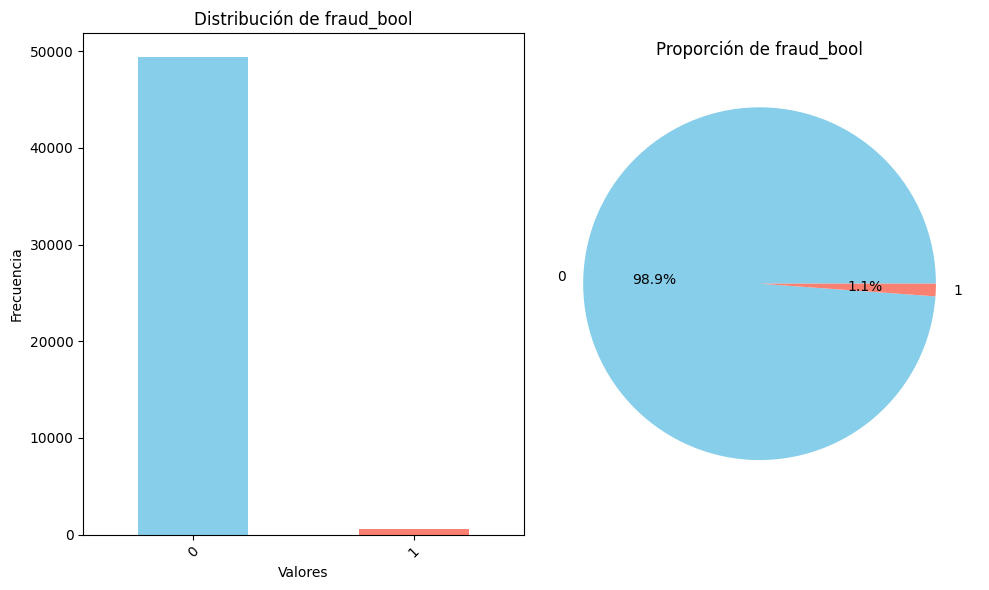

In [23]:
# Análisis de la variable objetivo fraud_bool en el dataset limpio
target_col = 'fraud_bool'

# Verificar si la columna existe en el dataset
if target_col in base_cleaned.columns:
    target_counts = base_cleaned[target_col].value_counts(dropna=False)
    target_pct = base_cleaned[target_col].value_counts(normalize=True, dropna=False) * 100
    
    res = pd.DataFrame({'conteo': target_counts, 'porcentaje_%': target_pct.round(2)})
    print(f"=== DISTRIBUCIÓN DE {target_col.upper()} ===")
    display(res)
    
    # Mostrar información adicional
    print(f"\nTotal de registros: {len(base_cleaned):,}")
    print(f"Valores únicos en {target_col}: {base_cleaned[target_col].nunique()}")
    
    # Crear visualización
    plt.figure(figsize=(10, 6))
    
    # Gráfico de barras
    plt.subplot(1, 2, 1)
    target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Distribución de {target_col}')
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    
    # Gráfico de pastel
    plt.subplot(1, 2, 2)
    target_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
    plt.title(f'Proporción de {target_col}')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"❌ La columna '{target_col}' no existe en el dataset.")
    print("Columnas disponibles:")
    print(base_cleaned.columns.tolist())

In [ ]:
# DEMOSTRACIÓN COMPLETA DEL PIPELINE DE LIMPIEZA
print("🚀 EJECUTANDO PIPELINE COMPLETO DE LIMPIEZA DE DATOS")
print("="*70)
print()

# Procesar todos los datasets
print("📊 Procesando todos los datasets...")
processed_data = process_all_datasets()

print("\n" + "="*70)
print("📋 CREANDO REPORTE DE CALIDAD...")

# Crear reporte de calidad
quality_report = create_data_quality_report(processed_data)
print("\n=== REPORTE DE CALIDAD DE DATOS ===")
display(quality_report)

print("\n" + "="*70)
print("💾 GUARDANDO DATASETS LIMPIOS...")

# Guardar todos los datasets limpios
saved_files = save_cleaned_datasets(processed_data)

print("\n" + "="*70)
print("✅ PIPELINE COMPLETADO EXITOSAMENTE!")
print()
print("📁 Archivos guardados en la carpeta 'cleaned_data/'")
print("📊 Reportes de calidad generados")
print("🎯 Datos listos para análisis posterior")
print()
print("Próximos pasos sugeridos:")
print("1. Revisar los reportes de limpieza generados")
print("2. Analizar las distribuciones de las variables objetivo")
print("3. Realizar análisis exploratorio de datos (EDA)")
print("4. Preparar datos para modelado de machine learning")

🚀 EJECUTANDO PIPELINE COMPLETO DE LIMPIEZA DE DATOS

📊 Procesando todos los datasets...
=== PROCESANDO TODOS LOS DATASETS ===

🔄 Procesando Base.csv...


✓ Duplicados eliminados: 0 filas (0.00%)
📊 fraud_bool: 11,029 outliers (1.10%) - método iqr
📊 income: 0 outliers (0.00%) - método iqr
📊 name_email_similarity: 0 outliers (0.00%) - método iqr
📊 prev_address_months_count: 157,320 outliers (15.73%) - método iqr
📊 current_address_months_count: 41,001 outliers (4.10%) - método iqr
📊 customer_age: 1,373 outliers (0.14%) - método iqr
📊 days_since_request: 94,834 outliers (9.48%) - método iqr
📊 intended_balcon_amount: 222,702 outliers (22.27%) - método iqr
📊 zip_count_4w: 59,871 outliers (5.99%) - método iqr
📊 velocity_6h: 9,005 outliers (0.90%) - método iqr
📊 velocity_24h: 2,917 outliers (0.29%) - método iqr
📊 velocity_4w: 0 outliers (0.00%) - método iqr
📊 bank_branch_count_8w: 175,243 outliers (17.52%) - método iqr
📊 date_of_birth_distinct_emails_4w: 9,734 outliers (0.97%) - método iqr
📊 credit_risk_score: 8,729 outliers (0.87%) - método iqr
📊 email_is_free: 0 outliers (0.00%) - método iqr
📊 phone_home_valid: 0 outliers (0.00%) - método iqr
